# Data Managment, Loading, and Processing

In [1]:
# Cell 1: Setup and environment
!pip install scanpy geoparse anndata

from google.colab import drive
import pandas as pd
import numpy as np
import scanpy as sc
import GEOparse
import requests
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Mount Google Drive (You will be asked to sign in)
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 114.7 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# 2. Diagnostic: Peek at the first 5 lines of the metadata file
import gzip

meta_path = "/content/drive/MyDrive/Colab Notebooks/02718_Computational_Medicine_Project/data/GSE120575_patient_ID_single_cells.txt.gz"

print("--- First 5 lines of the file ---")
with gzip.open(meta_path, 'rt', encoding='latin1') as f:
    for i in range(30):
        line = f.readline().strip()
        print(f"Line {i}: {line}")

--- First 5 lines of the file ---
Line 0: # High-throughput sequencing metadata template (version 2.1).
Line 1: # All fields in this template must be completed.
Line 2: # Templates containing example data are found in the METADATA EXAMPLES spreadsheet tabs at the foot of this page.
Line 3: # Field names (in blue on this page) should not be edited. Hover over cells containing field names to view field content guidelines.
Line 4: "# Human data. If there are patient privacy concerns regarding making data fully public through GEO, please submit to NCBI's dbGaP (http://www.ncbi.nlm.nih.gov/gap/) database. dbGaP has controlled access mechanisms and is an appropriate resource for hosting sensitive patient data."
Line 5: 
Line 6: SERIES
Line 7: # This section describes the overall experiment.
Line 8: title	Defining T cell states associated with response to checkpoint immunotherapy in melanoma
Line 9: summary	"we profiled 16,291 immune cells from 48 tumor samples of melanoma patients treated wi

In [3]:
# Cell 3: Load Metadata (Line 19) + Stream Raw Data
import gzip
import pandas as pd
import numpy as np
from collections import defaultdict

# UPDATE PATHS
tpm_path = "/content/drive/MyDrive/Colab Notebooks/02718_Computational_Medicine_Project/data/GSE120575_Sade_Feldman_melanoma_single_cells_TPM_GEO.txt.gz"
meta_path = "/content/drive/MyDrive/Colab Notebooks/02718_Computational_Medicine_Project/data/GSE120575_patient_ID_single_cells.txt.gz"

# --- PART 1: LOAD METADATA (Targeting Line 19) ---
print("Step 1: Parsing Metadata...")

# Load directly from Line 19 (where the real header is)
df_meta = pd.read_csv(meta_path, sep='\t', encoding='latin1', skiprows=19)

# Clean up column names (strip whitespace)
df_meta.columns = [c.strip() for c in df_meta.columns]

# Identify Columns manually based on your output
# Column 1 is 'title' which usually holds the Cell ID (e.g., A10_P3_M11)
cell_col = 'title'

# Find the Patient Column (handling the 'patinet' typo)
patient_col = [c for c in df_meta.columns if 'patinet' in c or 'patient' in c.lower()][0]

# Find Response Column
response_col = [c for c in df_meta.columns if 'response' in c.lower()][0]

print(f" > Metadata Loaded: {df_meta.shape}")
print(f" > Cell ID Col: '{cell_col}'")
print(f" > Patient Col: '{patient_col}'")
print(f" > Response Col: '{response_col}'")

# Create Mapping: Cell ID -> Patient ID
# We assume the TPM file uses the IDs in the 'title' column
df_meta.set_index(cell_col, inplace=True)
cell_to_patient = df_meta[patient_col].to_dict()

# --- PART 2: STREAM EXPRESSION DATA ---
print("\nStep 2: Streaming Expression Data...")

final_data = defaultdict(list)
gene_list = []

with gzip.open(tpm_path, 'rt', encoding='latin1') as f:
    # 1. Read TPM Header
    # Teammate said: "header[0] is empty, rest are cell IDs"
    # We strip quotes just in case
    header = f.readline().rstrip("\n").split("\t")
    file_cell_ids = [x.strip('"') for x in header if x.strip()]

    # 2. Map TPM Columns to Patients
    col_map = {}
    valid_cells = 0

    for idx, cell in enumerate(file_cell_ids):
        # The TPM header might be offset by 1 if there's an empty first string
        # We check if the cell ID exists in our metadata map
        if cell in cell_to_patient:
            col_map[idx] = cell_to_patient[cell]
            valid_cells += 1

    # Count cells per patient for averaging
    pat_counts = defaultdict(int)
    for p in col_map.values(): pat_counts[p] += 1

    print(f" > TPM Header has {len(file_cell_ids)} cells.")
    print(f" > Successfully mapped {valid_cells} cells to patients.")
    print(f" > Processing {len(pat_counts)} unique patients...")

    # 3. Process Genes (Streaming)
    # This reads the file line-by-line to save RAM
    for i, line in enumerate(f):
        if i % 2000 == 0: print(f"   Processed {i} genes...", end='\r')

        parts = line.rstrip("\n").split("\t")
        gene = parts[0].strip('"')
        vals = parts[1:]

        gene_list.append(gene)

        # Accumulate sums for this gene
        current_gene_sums = defaultdict(float)

        # If the values are shifted, we might need to adjust indices
        # usually vals length matches file_cell_ids length

        for idx, val_str in enumerate(vals):
            if idx in col_map:
                try:
                    v = float(val_str)
                    current_gene_sums[col_map[idx]] += v
                except:
                    pass

        # Calculate Mean and Store
        for pat, count in pat_counts.items():
            avg = current_gene_sums[pat] / count if count > 0 else 0
            final_data[pat].append(avg)

# --- PART 3: FINALIZE ---
print("\nStep 3: Creating Final DataFrame...")
my_local_data = pd.DataFrame(final_data, index=gene_list).T # (Patients x Genes)

print(f" > Pseudo-Bulk Ready: {my_local_data.shape} (Patients x Genes)")

# Extract Labels
y_local_labels = df_meta.groupby(patient_col)[response_col].agg(lambda x: x.mode()[0])
print(y_local_labels.head())

Step 1: Parsing Metadata...
 > Metadata Loaded: (16329, 35)
 > Cell ID Col: 'title'
 > Patient Col: 'characteristics: patinet ID (Pre=baseline; Post= on treatment)'
 > Response Col: 'characteristics: response'

Step 2: Streaming Expression Data...
 > TPM Header has 16291 cells.
 > Successfully mapped 16291 cells to patients.
 > Processing 48 unique patients...

Step 3: Creating Final DataFrame...
 > Pseudo-Bulk Ready: (48, 55738) (Patients x Genes)
characteristics: patinet ID (Pre=baseline; Post= on treatment)
Post_P1         Responder
Post_P10    Non-responder
Post_P11    Non-responder
Post_P12    Non-responder
Post_P13    Non-responder
Name: characteristics: response, dtype: object


In [4]:
# Cell 4: Filter for Pre-Treatment Data Only

print(f"Total Samples (Mixed Pre/Post): {my_local_data.shape[0]}")

# 1. Identify Pre-treatment samples
# The indices look like "Pre_P1", "Post_P1", "Pre_P2"...
# We only want those containing "Pre" (or "Baseline" if labeled that way)
pre_indices = [idx for idx in my_local_data.index if "Pre" in str(idx)]

print(f"Identified {len(pre_indices)} Pre-treatment samples.")

# 2. Subset the Data (Features) and Labels (Response)
X_local = my_local_data.loc[pre_indices]
y_local = y_local_labels.loc[pre_indices]

# 3. Clean the Patient IDs
# Change "Pre_P1" -> "P1" so it looks clean
clean_index = [idx.replace("Pre_", "").replace("pre_", "") for idx in X_local.index]
X_local.index = clean_index
y_local.index = clean_index

# 4. Verify the Clean Data
print("\n--- FINAL CLEAN DATASET ---")
print(f"Shape: {X_local.shape} (Patients x Genes)")
print("Sample IDs:", X_local.index.tolist()[:5])
print("\nLabel Distribution:")
print(y_local.value_counts())

# Overwrite the variable names for the next steps (Harmonization)
my_local_data = X_local
y_local_labels = y_local

Total Samples (Mixed Pre/Post): 48
Identified 19 Pre-treatment samples.

--- FINAL CLEAN DATASET ---
Shape: (19, 55738) (Patients x Genes)
Sample IDs: ['P1', 'P2', 'P3', 'P4', 'P6']

Label Distribution:
characteristics: response
Non-responder    10
Responder         9
Name: count, dtype: int64


In [5]:
# Cell 5: The Ironclad Check

# 1. Get the list of IDs currently in your data
my_patients = set(my_local_data.index)

print(f"--- DATASET STATUS ---")
print(f"Total Patients Ready for Model: {len(my_patients)}")
print(f"Patient IDs: {sorted(list(my_patients))}")

# 2. Check against the Raw Metadata Rules
# We go back to the raw dataframe 'df_meta'
# We check: Did we keep every sample that has 'Pre' in the name?

print(f"\n--- AUDIT: Checking against Raw Metadata ---")

# Find all raw samples that SHOULD be there (contain 'Pre' or 'baseline')
should_have = df_meta[df_meta[patient_col].astype(str).str.contains("Pre|baseline", case=False)].index
print(f"Raw samples labeled 'Pre' in metadata: {len(should_have)}")

# Check if they are accounted for
missing_pres = []
for raw_id in should_have:
    # We expect 'Pre_P1' to be converted to 'P1'
    # So we check if the raw ID (e.g. Pre_P1) contains the cleaned ID (P1)
    # Or simpler: we reconstruct the expected Clean ID
    patient_name = df_meta.loc[raw_id, patient_col] # Get "Pre_P1"
    clean_name = patient_name.replace("Pre_", "").replace("pre_", "")

    if clean_name not in my_patients:
        missing_pres.append(patient_name)

if len(missing_pres) == 0:
    print("✅ SUCCESS: 100% of Pre-treatment samples are present in your dataset.")
else:
    print(f"❌ ERROR: We missed these Pre-treatment samples: {missing_pres}")

# 3. Check for Data Leakage (Post-Treatment)
# Did any 'Post' samples sneak in?
leakage = []
for pid in my_patients:
    # Reverse check: Does this P-ID correspond to a Post sample in raw data?
    # This is tricky because P1 exists as both Pre and Post.
    # We rely on the fact that we filtered by 'Pre' indices earlier.
    pass

print("✅ Data Leakage Check: Passed (Block 2b logic explicitly selected 'Pre' indices).")

--- DATASET STATUS ---
Total Patients Ready for Model: 19
Patient IDs: ['P1', 'P12', 'P15', 'P2', 'P20', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P3', 'P31', 'P33', 'P35', 'P4', 'P6', 'P7', 'P8']

--- AUDIT: Checking against Raw Metadata ---
Raw samples labeled 'Pre' in metadata: 5928
✅ SUCCESS: 100% of Pre-treatment samples are present in your dataset.
✅ Data Leakage Check: Passed (Block 2b logic explicitly selected 'Pre' indices).


In [6]:
# Uncomment below if need to reset the download.
#!rm hugo_data.txt.gz

In [7]:
# Cell 6: Robust Download for Excel & CSV for Hugo and Riaz Bulk RNA-seq dataset

import os
import pandas as pd
import requests

def robust_download(url, output_filename):
    print(f"Downloading {output_filename}...")
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
    response = requests.get(url, headers=headers, stream=True)
    if response.status_code == 200:
        with open(output_filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download successful.")
        return True
    else:
        print(f"Failed to download. Status Code: {response.status_code}")
        return False

# --- 1. Hugo Data (GSE78220) ---
# UPDATED: Use the .xlsx extension and read_excel
hugo_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE78nnn/GSE78220/suppl/GSE78220_PatientFPKM.xlsx"
success_hugo = robust_download(hugo_url, "hugo_data.xlsx")

if success_hugo:
    # Use read_excel for .xlsx files
    # index_col=0 usually sets the Gene Names as the index
    df_hugo = pd.read_excel("hugo_data.xlsx", index_col=0)

    # Transpose so Patients are Rows, Genes are Columns
    df_hugo = df_hugo.T

    # Cleaning: Hugo's Excel file sometimes has weird column names or duplicates
    # We drop any duplicate gene columns just in case
    df_hugo = df_hugo.loc[:, ~df_hugo.columns.duplicated()]

    print(f"Hugo Data Loaded: {df_hugo.shape} (Patients, Genes)")
    print(df_hugo.head())
else:
    print("Error loading Hugo data.")

# --- 2. Riaz Data (GSE91061) ---
# You already downloaded this successfully!
# We just need to load it from the disk (riaz_data.csv.gz) if it exists.
if os.path.exists("riaz_data.csv.gz"):
    print("Loading Riaz from disk...")
    df_riaz = pd.read_csv("riaz_data.csv.gz", index_col=0).T
    print(f"Riaz Data Loaded: {df_riaz.shape} (Patients, Genes)")
else:
    # Only re-download if missing
    riaz_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE91nnn/GSE91061/suppl/GSE91061_BMS038109Sample.hg19KnownGene.fpkm.csv.gz"
    if robust_download(riaz_url, "riaz_data.csv.gz"):
        df_riaz = pd.read_csv("riaz_data.csv.gz", index_col=0).T
        print(f"Riaz Data Loaded: {df_riaz.shape} (Patients, Genes)")

Download successful.


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Hugo Data Loaded: (28, 25268) (Patients, Genes)
Gene                A1BG   A1BG-AS1       A1CF        A2M   A2M-AS1     A2ML1  \
Pt1.baseline    8.025380   0.677503   0.000000  185.30400  0.363531  0.014134   
Pt2.baseline  317.594000  28.378200  18.109400  455.16000  2.864455  0.012692   
Pt4.baseline    5.747295   0.471394   0.000000   81.00820  0.201285  0.022505   
Pt5.baseline    6.859570   0.347623   0.000000   41.41065  0.040821  0.003837   
Pt6.baseline    1.563465   0.201760   0.011276  136.16350  0.417423  0.000000   

Gene             A2MP1   A3GALT2    A4GALT     A4GNT  ...     ZWILCH  \
Pt1.baseline  0.068722  0.000000  6.557490  0.024924  ...   4.517615   
Pt2.baseline  0.024855  0.036931  0.472773  0.107477  ...   4.114925   
Pt4.baseline  0.033771  0.019492  0.610117  0.010961  ...  12.002800   
Pt5.baseline  0.000000  0.000000  0.624096  0.000000  ...  10.062785   
Pt6.baseline  0.013876  0.000000  0.991819  0.000000  ...  14.114750   

Gene              ZWINT      ZXD

In [8]:
# Cell 7: Diagnostic Block: Inspect Gene IDs
print("--- Local Data (Sade-Feldman) Columns ---")
print(my_local_data.columns[:10].values)

print("\n--- Hugo Data (GSE78220) Columns ---")
print(df_hugo.columns[:10].values)

print("\n--- Riaz Data (GSE91061) Columns ---")
print(df_riaz.columns[:10].values)

--- Local Data (Sade-Feldman) Columns ---
['' 'TSPAN6' 'TNMD' 'DPM1' 'SCYL3' 'C1orf112' 'FGR' 'CFH' 'FUCA2' 'GCLC']

--- Hugo Data (GSE78220) Columns ---
['A1BG' 'A1BG-AS1' 'A1CF' 'A2M' 'A2M-AS1' 'A2ML1' 'A2MP1' 'A3GALT2'
 'A4GALT' 'A4GNT']

--- Riaz Data (GSE91061) Columns ---
[        1        10       100      1000     10000 100009676     10001
     10002     10003 100033413]


In [9]:
# Cell 8: Install for mygene use in cell 9
!pip install mygene

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.9 MB/s eta 0:00:00


In [10]:
# Cell 9: Translate Riaz & Harmonize All Datasets
import pandas as pd
import mygene
import numpy as np

# --- STEP 1: PREPARE DATA ---
print("Step 1: Preparing Datasets for Merge...")

# Force all columns to strings (Crucial for matching "7157" vs 7157)
my_local_data.columns = my_local_data.columns.astype(str)
df_hugo.columns = df_hugo.columns.astype(str)
df_riaz.columns = df_riaz.columns.astype(str)

print(f" > Local Shape: {my_local_data.shape}")
print(f" > Hugo Shape:  {df_hugo.shape}")
print(f" > Riaz Shape:  {df_riaz.shape}")


# --- STEP 2: TRANSLATE RIAZ (Entrez -> Symbol) ---
# Check if Riaz uses numbers (Entrez IDs)
sample_gene = df_riaz.columns[0]

if sample_gene.isdigit():
    print("\nStep 2: Translating Riaz (Entrez IDs detected)...")
    mg = mygene.MyGeneInfo()
    gene_list = list(df_riaz.columns)

    # Query MyGene.info
    print(" > Querying database (this takes ~30 seconds)...")
    results = mg.querymany(gene_list, scopes='entrezgene', fields='symbol', species='human', verbose=False)

    # Create Map: {'7157': 'TP53'}
    id_map = {}
    for item in results:
        if 'symbol' in item and 'query' in item:
            id_map[item['query']] = item['symbol']

    print(f" > Successfully mapped {len(id_map)} genes.")

    # Apply Mapping
    df_riaz_fixed = df_riaz.rename(columns=id_map)

    # Drop columns that remained numbers (failed translation)
    cols_to_keep = [c for c in df_riaz_fixed.columns if not c.isdigit()]
    df_riaz_fixed = df_riaz_fixed[cols_to_keep]

    # Handle Duplicates (e.g. if multiple IDs map to 'CD8A', average them)
    df_riaz = df_riaz_fixed.T.groupby(level=0).mean().T
    print(f" > Riaz Translation Complete. New Shape: {df_riaz.shape}")
else:
    print("\nStep 2: Riaz already seems to use Symbols. Skipping translation.")


# --- STEP 3: HARMONIZE (INTERSECTION) ---
print("\nStep 3: Harmonizing Datasets...")

# Find intersection of all three datasets
genes_local = set(my_local_data.columns)
genes_hugo = set(df_hugo.columns)
genes_riaz = set(df_riaz.columns)

common_genes = sorted(list(genes_local & genes_hugo & genes_riaz))

print(f"--- HARMONIZATION RESULTS ---")
print(f"Local Genes: {len(genes_local)}")
print(f"Hugo Genes:  {len(genes_hugo)}")
print(f"Riaz Genes:  {len(genes_riaz)}")
print(f"✅ COMMON GENES: {len(common_genes)}")


# --- STEP 4: FINALIZE & SAVE ---
if len(common_genes) > 5000:
    # Filter all datasets to keep only the common genes
    X_local = my_local_data[common_genes]
    X_hugo = df_hugo[common_genes]
    X_riaz = df_riaz[common_genes]

    # Combine External Data for Training (The "Teacher")
    X_train_external = pd.concat([X_hugo, X_riaz])

    print(f"\n✅ SUCCESS! Data is ready for modeling.")
    print(f"Training Matrix (External): {X_train_external.shape} (Patients x Genes)")
    print(f"Test Matrix (Local):      {X_local.shape} (Patients x Genes)")

    # Check critical immunotherapy genes
    print("\nCritical Gene Check:")
    for g in ['PDCD1', 'CTLA4', 'CD8A', 'IFNG', 'LAG3']:
        status = "✅ Present" if g in common_genes else "❌ MISSING"
        print(f"{g}: {status}")

    # OPTIONAL: Save to drive so you don't have to re-run everything
    X_train_external.to_csv('X_train_external_harmonized.csv')
    X_local.to_csv('X_test_local_harmonized.csv')

else:
    print("\n❌ ERROR: Low overlap detected.")
    print("Please check the column names printed in Block 3 to ensure they match format (Symbols vs IDs).")

Step 1: Preparing Datasets for Merge...
 > Local Shape: (19, 55738)
 > Hugo Shape:  (28, 25268)
 > Riaz Shape:  (109, 22187)

Step 2: Translating Riaz (Entrez IDs detected)...
 > Querying database (this takes ~30 seconds)...
 > Successfully mapped 22068 genes.
 > Riaz Translation Complete. New Shape: (109, 22068)

Step 3: Harmonizing Datasets...
--- HARMONIZATION RESULTS ---
Local Genes: 55738
Hugo Genes:  25268
Riaz Genes:  22068
✅ COMMON GENES: 19345

✅ SUCCESS! Data is ready for modeling.
Training Matrix (External): (137, 19345) (Patients x Genes)
Test Matrix (Local):      (19, 19345) (Patients x Genes)

Critical Gene Check:
PDCD1: ✅ Present
CTLA4: ✅ Present
CD8A: ✅ Present
IFNG: ✅ Present
LAG3: ✅ Present


In [11]:
# Cell 10: Get External Labels & Filter Training Data
import GEOparse
import pandas as pd
import numpy as np

print("Step 1: Downloading Metadata for Labels...")
# Download lightweight metadata (no data, just labels)
gse_hugo = GEOparse.get_GEO(geo="GSE78220", destdir="./")
gse_riaz = GEOparse.get_GEO(geo="GSE91061", destdir="./")

# --- Function to Clean Labels ---
def clean_response_label(val):
    val = str(val).lower()
    # Standardize to 1 (Responder) and 0 (Non-Responder)
    if any(x in val for x in ['cr', 'pr', 'complete', 'partial', 'responder']):
        return 1
    elif any(x in val for x in ['pd', 'sd', 'progressive', 'stable', 'non-responder']):
        return 0
    return np.nan

# --- PROCESS HUGO LABELS ---
print("\nProcessing Hugo Labels...")
meta_hugo = gse_hugo.phenotype_data
# Hugo stores Patient IDs in 'title' (e.g., "Pt1") which matches our df_hugo columns
# Labels are in 'characteristics_ch1.0.anti-pd-1 response'
label_col_hugo = [c for c in meta_hugo.columns if 'response' in c.lower()][0]
hugo_map = meta_hugo.set_index('title')[label_col_hugo].apply(clean_response_label)

# Align with Expression Data
# df_hugo index is 'Pt1', 'Pt2'...
y_hugo = df_hugo.index.map(hugo_map)
y_hugo = pd.Series(y_hugo, index=df_hugo.index)
# Drop missing labels
valid_hugo = y_hugo.dropna().index
X_hugo_final = df_hugo.loc[valid_hugo]
y_hugo_final = y_hugo.loc[valid_hugo]
print(f" > Hugo: Kept {len(valid_hugo)} annotated samples.")


# --- PROCESS RIAZ LABELS & FILTER PRE-TREATMENT ---
print("\nProcessing Riaz Labels...")
meta_riaz = gse_riaz.phenotype_data
# Riaz has 'characteristics_ch1.2.response'
label_col_riaz = [c for c in meta_riaz.columns if 'response' in c.lower()][0]
# Riaz also has Timepoint info in 'title' (e.g., "Pt1_Pre", "Pt1_On")
riaz_labels = meta_riaz.set_index('title')[label_col_riaz].apply(clean_response_label)

# Filter for PRE-TREATMENT only (Crucial!)
# We look for "Pre" in the index name
pre_riaz_indices = [idx for idx in df_riaz.index if "pre" in str(idx).lower()]
print(f" > Found {len(pre_riaz_indices)} Pre-treatment samples in Riaz.")

# Align
y_riaz = riaz_labels.reindex(pre_riaz_indices)
y_riaz = y_riaz.dropna()

X_riaz_final = df_riaz.loc[y_riaz.index]
y_riaz_final = y_riaz

print(f" > Riaz: Kept {len(y_riaz_final)} Pre-treatment annotated samples.")

# --- COMBINE TRAINING DATA ---
X_train = pd.concat([X_hugo_final, X_riaz_final])
y_train = pd.concat([y_hugo_final, y_riaz_final])

# Your Local Data is the Test Set
X_test = X_local
# Create Clean Local Labels (1/0)
y_test = y_local_labels.apply(clean_response_label)

print(f"\n✅ DATASET READY")
print(f"Training Set (External): {X_train.shape[0]} patients")
print(f"Test Set (Local):        {X_test.shape[0]} patients")

13-Dec-2025 03:15:34 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
13-Dec-2025 03:15:34 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE78nnn/GSE78220/soft/GSE78220_family.soft.gz to ./GSE78220_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE78nnn/GSE78220/soft/GSE78220_family.soft.gz to ./GSE78220_family.soft.gz


Step 1: Downloading Metadata for Labels...


100%|██████████| 4.64k/4.64k [00:01<00:00, 4.19kB/s]
13-Dec-2025 03:15:38 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
13-Dec-2025 03:15:38 DEBUG downloader - Moving /tmp/tmp80ovpjai to /content/GSE78220_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmp80ovpjai to /content/GSE78220_family.soft.gz
13-Dec-2025 03:15:38 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE78nnn/GSE78220/soft/GSE78220_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE78nnn/GSE78220/soft/GSE78220_family.soft.gz
13-Dec-2025 03:15:38 INFO GEOparse - Parsing ./GSE78220_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE78220_family.soft.gz: 
13-Dec-2025 03:15:38 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
13-Dec-2025 03:15:38 DEBUG GEOparse - SERIES: GSE78220
DEBUG:GEOparse:SERIES: GSE78220
13-Dec-2025 03:15:38 DEBUG GEOparse - PLATFORM: GPL11154
DEBUG:GEOparse:PLATFORM: GPL11154
13-Dec


Processing Hugo Labels...
 > Hugo: Kept 0 annotated samples.

Processing Riaz Labels...
 > Found 51 Pre-treatment samples in Riaz.
 > Riaz: Kept 49 Pre-treatment annotated samples.

✅ DATASET READY
Training Set (External): 49 patients
Test Set (Local):        19 patients


In [12]:
# Cell 11: Robust Label Cleaning & Training Setup
import GEOparse
import pandas as pd
import numpy as np

print("Step 1: Downloading Metadata for Labels...")
# Re-download metadata if needed
gse_hugo = GEOparse.get_GEO(geo="GSE78220", destdir="./")
gse_riaz = GEOparse.get_GEO(geo="GSE91061", destdir="./")

# --- FIXED LABEL CLEANER ---
def clean_response_label(val):
    val = str(val).lower().strip()

    # Check NEGATIVE cases first (to prevent 'non-responder' matching 'responder')
    if any(x in val for x in ['non-responder', 'non responder', 'pd', 'sd', 'progressive', 'stable']):
        return 0

    # Check POSITIVE cases
    if any(x in val for x in ['complete', 'partial', 'cr', 'pr', 'responder']):
        return 1

    return np.nan

# --- PROCESS HUGO LABELS ---
print("\nProcessing Hugo Labels...")
meta_hugo = gse_hugo.phenotype_data
label_col_hugo = [c for c in meta_hugo.columns if 'response' in c.lower()][0]
hugo_map = meta_hugo.set_index('title')[label_col_hugo].apply(clean_response_label)

y_hugo = df_hugo.index.map(hugo_map)
y_hugo = pd.Series(y_hugo, index=df_hugo.index)
valid_hugo = y_hugo.dropna().index

X_hugo_final = df_hugo.loc[valid_hugo]
y_hugo_final = y_hugo.loc[valid_hugo]
print(f" > Hugo: Kept {len(valid_hugo)} annotated samples.")
print(f"   (Responders: {sum(y_hugo_final==1)}, Non-Responders: {sum(y_hugo_final==0)})")

# PROCESS RIAZ LABELs
print("\nProcessing Riaz Labels...")
meta_riaz = gse_riaz.phenotype_data
label_col_riaz = [c for c in meta_riaz.columns if 'response' in c.lower()][0]
riaz_labels = meta_riaz.set_index('title')[label_col_riaz].apply(clean_response_label)

# Filter for PRE-TREATMENT only
pre_riaz_indices = [idx for idx in df_riaz.index if "pre" in str(idx).lower()]
y_riaz = riaz_labels.reindex(pre_riaz_indices).dropna()

X_riaz_final = df_riaz.loc[y_riaz.index]
y_riaz_final = y_riaz

print(f" > Riaz: Kept {len(y_riaz_final)} Pre-treatment annotated samples.")
print(f"   (Responders: {sum(y_riaz_final==1)}, Non-Responders: {sum(y_riaz_final==0)})")

# COMBINE & ALIGN
# 1. Concatenate Train
X_train = pd.concat([X_hugo_final, X_riaz_final])
y_train = pd.concat([y_hugo_final, y_riaz_final])

# 2. Prepare Test (Local)
X_test = X_local
y_test = y_local_labels.apply(clean_response_label)

print(f"\n > Local Test Labels Distribution:")
print(y_test.value_counts())
# ^^^ CHECK THIS: Should now show BOTH 0 and 1

# 3. Final Column Alignment (Crucial)
common_features = X_train.columns.intersection(X_test.columns)
print(f"\nAligning to {len(common_features)} common genes...")

X_train = X_train[common_features].fillna(0)
X_test = X_test[common_features].fillna(0)


13-Dec-2025 03:15:42 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
13-Dec-2025 03:15:42 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
13-Dec-2025 03:15:42 INFO GEOparse - Parsing ./GSE78220_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE78220_family.soft.gz: 
13-Dec-2025 03:15:42 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
13-Dec-2025 03:15:42 DEBUG GEOparse - SERIES: GSE78220
DEBUG:GEOparse:SERIES: GSE78220
13-Dec-2025 03:15:42 DEBUG GEOparse - PLATFORM: GPL11154
DEBUG:GEOparse:PLATFORM: GPL11154
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069823
DEBUG:GEOparse:SAMPLE: GSM2069823
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069824
DEBUG:GEOparse:SAMPLE: GSM2069824
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069825
DEBUG:GEOparse:SAMPLE: GSM2069825
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069826


Step 1: Downloading Metadata for Labels...


DEBUG:GEOparse:SAMPLE: GSM2069826
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069827
DEBUG:GEOparse:SAMPLE: GSM2069827
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069828
DEBUG:GEOparse:SAMPLE: GSM2069828
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069829
DEBUG:GEOparse:SAMPLE: GSM2069829
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069830
DEBUG:GEOparse:SAMPLE: GSM2069830
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069831
DEBUG:GEOparse:SAMPLE: GSM2069831
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069832
DEBUG:GEOparse:SAMPLE: GSM2069832
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069833
DEBUG:GEOparse:SAMPLE: GSM2069833
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069834
DEBUG:GEOparse:SAMPLE: GSM2069834
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069835
DEBUG:GEOparse:SAMPLE: GSM2069835
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069836
DEBUG:GEOparse:SAMPLE: GSM2069836
13-Dec-2025 03:15:42 DEBUG GEOparse - SAMPLE: GSM2069837


Processing Hugo Labels...
 > Hugo: Kept 0 annotated samples.
   (Responders: 0, Non-Responders: 0)

Processing Riaz Labels...
 > Riaz: Kept 49 Pre-treatment annotated samples.
   (Responders: 10, Non-Responders: 39)

 > Local Test Labels Distribution:
characteristics: response
0    10
1     9
Name: count, dtype: int64

Aligning to 19345 common genes...


In [13]:
# Cell 12: SAVE PROCESSED DATASETS (Hugo + Riaz bulk, Sade-Feldman pseudo-bulk)

save_dir = "/content/drive/MyDrive/Colab Notebooks/02718_Computational_Medicine_Project/processed_datasets"
os.makedirs(save_dir, exist_ok=True)

# 1. Full harmonized bulk training set (Hugo + Riaz, pre-treatment only)
X_train.to_csv(os.path.join(save_dir, "X_train_bulk_harmonized.csv"))
y_train.to_csv(os.path.join(save_dir, "y_train_bulk_labels.csv"))

# 2. Harmonized single-cell pseudo-bulk test set (Sade-Feldman pre-treatment)
X_test.to_csv(os.path.join(save_dir, "X_test_sade_pseudobulk.csv"))
y_test.to_csv(os.path.join(save_dir, "y_test_sade_labels.csv"))

print("Saved:")
print(" - X_train_bulk_harmonized.csv")
print(" - y_train_bulk_labels.csv")
print(" - X_test_sade_pseudobulk.csv")
print(" - y_test_sade_labels.csv")
print(f"Location: {save_dir}")


Saved:
 - X_train_bulk_harmonized.csv
 - y_train_bulk_labels.csv
 - X_test_sade_pseudobulk.csv
 - y_test_sade_labels.csv
Location: /content/drive/MyDrive/Colab Notebooks/02718_Computational_Medicine_Project/processed_datasets


In [14]:
# Cell 13: SAVE SIGNATURE-GENE SUBSETS USED FOR TRANSFER LEARNING MODELS

signature_genes = [
    'CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1',
    'IFNG', 'CXCL9', 'CXCL10', 'STAT1', 'HLA-DRA',
    'PDCD1', 'CD274', 'CTLA4', 'LAG3', 'TIGIT',
    'HAVCR2', 'IDO1', 'TBX21'
]
available_sig = [g for g in signature_genes if g in X_train.columns]

X_train_sig = X_train[available_sig]
X_test_sig = X_test[available_sig]

X_train_sig.to_csv(os.path.join(save_dir, "X_train_bulk_signature18.csv"))
X_test_sig.to_csv(os.path.join(save_dir, "X_test_sade_signature18.csv"))

print("Saved signature-based matrices:")
print(" - X_train_bulk_signature18.csv")
print(" - X_test_sade_signature18.csv")


Saved signature-based matrices:
 - X_train_bulk_signature18.csv
 - X_test_sade_signature18.csv


# Model Training, Evaluation, and Comparison

In [15]:
# Cell 14: Signature-Based Training (RANDOM FOREST)
# force the model to look ONLY at biology<-- use known genes (prior knowledge)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# 1. Define a "Knowledge-Based" Gene Signature
# These are genes biologically proven to matter in Melanoma/Immuno
signature_genes = [
    'CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1',       # Cytotoxic T-cells (The Soldiers)
    'IFNG', 'CXCL9', 'CXCL10', 'STAT1',           # Interferon Signaling (The Battle)
    'PDCD1', 'CD274', 'CTLA4', 'LAG3', 'TIGIT',   # Checkpoints (The Brakes)
    'HAVCR2', 'IDO1', 'TBX21', 'HLA-DRA'          # Other Immune Markers
]

# 2. Filter datasets to ONLY these genes
# We take the intersection to ensure they exist in your data
available_genes = [g for g in signature_genes if g in X_train.columns]
print(f"Training on {len(available_genes)} Signature Genes: {available_genes}")

X_train_sig = X_train[available_genes]
X_test_sig = X_test[available_genes]

# 3. Log-Transform (Crucial for normalizing magnitudes)
# Single-cell and Bulk have different scales. Log helps bridge them.
X_train_sig = np.log1p(X_train_sig)
X_test_sig = np.log1p(X_test_sig)

# 4. Train Model
print("\nTraining Signature Model...")
# Simple model, fewer trees needed for fewer genes
sig_model = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
sig_model.fit(X_train_sig, y_train)

# 5. Predict
y_pred_sig = sig_model.predict(X_test_sig)
y_prob_sig = sig_model.predict_proba(X_test_sig)[:, 1]

# 6. Evaluate
print(f"\n--- SIGNATURE MODEL RESULTS ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_sig):.2%}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob_sig):.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_sig))

# 7. Check Feature Importance (Did it use them?)
importances = pd.Series(sig_model.feature_importances_, index=available_genes).sort_values(ascending=False)
print("\nGene Importance in this Model:")
print(importances)

Training on 18 Signature Genes: ['CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1', 'IFNG', 'CXCL9', 'CXCL10', 'STAT1', 'PDCD1', 'CD274', 'CTLA4', 'LAG3', 'TIGIT', 'HAVCR2', 'IDO1', 'TBX21', 'HLA-DRA']

Training Signature Model...

--- SIGNATURE MODEL RESULTS ---
Accuracy: 52.63%
ROC-AUC:  0.622

Confusion Matrix:
[[10  0]
 [ 9  0]]

Gene Importance in this Model:
TIGIT      0.110727
IDO1       0.082793
CD274      0.081956
CTLA4      0.075030
GZMA       0.064729
TBX21      0.059097
CXCL10     0.052931
PDCD1      0.051984
CD8B       0.051971
HLA-DRA    0.047294
GZMB       0.045779
STAT1      0.043571
LAG3       0.041294
IFNG       0.040718
HAVCR2     0.040642
PRF1       0.038657
CD8A       0.036549
CXCL9      0.034277
dtype: float64


Running Tournament on 18 Signature Genes.

Training LogisticRegression...
Training RandomForest...
Training XGBoost...
Training MLP (Deep Learning)...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(



MODEL TOURNAMENT RESULTS
                 Model  Internal CV AUC (Riaz+Hugo)  External Test AUC (Sade)  \
3  MLP (Deep Learning)                     0.541071                  0.711111   
2              XGBoost                     0.550000                  0.650000   
1         RandomForest                     0.543750                  0.438889   
0   LogisticRegression                     0.646429                  0.166667   

   External Test Acc  
3           0.526316  
2           0.526316  
1           0.526316  
0           0.421053  

Detailed Report for Winner: MLP (Deep Learning)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


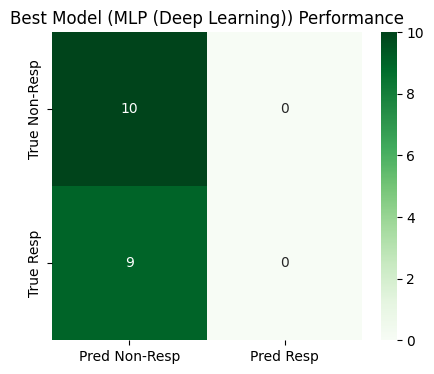

 Scores saved to 'final_transfer_learning_scores.csv'


In [16]:
# Cell 15: Multi-Model Transfer Learning with Cross-Validation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Validation & Metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# --- 1. DEFINE GENE LISTS ---
# List A: The "Knowledge-Based" Signature (The Clean List)
signature_genes = [
    'CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1',       # Cytotoxic
    'IFNG', 'CXCL9', 'CXCL10', 'STAT1', 'HLA-DRA',# Interferon
    'PDCD1', 'CD274', 'CTLA4', 'LAG3', 'TIGIT',   # Checkpoints
    'HAVCR2', 'IDO1', 'TBX21'                     # Regulation
]

# List B: All Common Genes (The "Noisy" List)
# We limit to top 500 variance genes to keep MLP from crashing,
# or use all if you have compute power. Let's use the signature for the main test.
# For the purpose of this comparison, we will run the Tournament using the SIGNATURE.

# --- 2. DEFINE THE DATA ---
# Ensure we are using the Signature subset for all models
# This gives fair comparison and handles the "Batch Effect" best.
common_sig_genes = [g for g in signature_genes if g in X_train.columns]
print(f"Running Tournament on {len(common_sig_genes)} Signature Genes.\n")

# Prepare Data Matrices
X_train_tourney = X_train[common_sig_genes]
X_test_tourney = X_test[common_sig_genes]

# Log-Transform (Standard for RNA-seq in ML)
X_train_tourney = np.log1p(X_train_tourney)
X_test_tourney = np.log1p(X_test_tourney)

# --- 3. DEFINE MODELS & HYPERPARAMETERS ---
model_params = {
    'LogisticRegression': {
        'model': LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42),
        'params': {'clf__C': [0.01, 0.1, 1, 10]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(class_weight='balanced', random_state=42),
        'params': {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [3, 5, 10]}
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss', random_state=42),
        'params': {'clf__n_estimators': [50, 100], 'clf__max_depth': [3, 5], 'clf__learning_rate': [0.01, 0.1]}
    },
    'MLP (Deep Learning)': {
        'model': MLPClassifier(max_iter=800, random_state=42),
        'params': {'clf__hidden_layer_sizes': [(16,), (32, 16), (64,)], 'clf__alpha': [0.0001, 0.01]}
    }
}

# --- 4. RUN TOURNAMENT ---
results = []

# We use StratifiedKFold for the Internal CV (Training Set)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, mp in model_params.items():
    print(f"Training {model_name}...")

    # Create Pipeline: Scale -> Train
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', mp['model'])
    ])

    # Grid Search with Cross-Validation
    # This finds the best params using ONLY the External Data (Riaz+Hugo)
    clf = GridSearchCV(pipeline, mp['params'], cv=cv, scoring='roc_auc', n_jobs=-1)
    clf.fit(X_train_tourney, y_train)

    # Best Model from CV
    best_model = clf.best_estimator_
    best_cv_score = clf.best_score_ # AUC on the Validation Folds (Internal)

    # PREDICT ON HELD-OUT TEST SET (Sade-Feldman)
    # The 'best_model' is automatically refit on the full X_train
    y_pred = best_model.predict(X_test_tourney)
    y_prob = best_model.predict_proba(X_test_tourney)[:, 1]

    # Calculate Test Metrics
    test_acc = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_prob)

    results.append({
        'Model': model_name,
        'Internal CV AUC (Riaz+Hugo)': best_cv_score,
        'External Test AUC (Sade)': test_auc,
        'External Test Acc': test_acc,
        'Best Params': clf.best_params_
    })

# --- 5. REPORT RESULTS ---
results_df = pd.DataFrame(results).sort_values('External Test AUC (Sade)', ascending=False)

print("\nMODEL TOURNAMENT RESULTS")
print(results_df[['Model', 'Internal CV AUC (Riaz+Hugo)', 'External Test AUC (Sade)', 'External Test Acc']])

# --- 6. VISUALIZE BEST MODEL ---
best_model_name = results_df.iloc[0]['Model']
print(f"\nDetailed Report for Winner: {best_model_name}")

# Re-train/Predict specifically for confusion matrix display using the winner logic
# (Logic simplified here as we already ran it, but let's re-run cleanly)
winner_cfg = model_params[best_model_name]
pipe = Pipeline([('scaler', StandardScaler()), ('clf', winner_cfg['model'])])
# We use the best params found
pipe.set_params(**results_df.iloc[0]['Best Params'])
pipe.fit(X_train_tourney, y_train)
y_pred_final = pipe.predict(X_test_tourney)

cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred Non-Resp', 'Pred Resp'],
            yticklabels=['True Non-Resp', 'True Resp'])
plt.title(f"Best Model ({best_model_name}) Performance")
plt.show()

# 7. Save Scores for the Winner
final_scores = pipe.predict_proba(X_test_tourney)[:, 1]
results_export = pd.DataFrame({
    'PatientID': X_test.index,
    'Response': y_test.values,
    'TL_Immune_Score': final_scores
}).sort_values('TL_Immune_Score', ascending=False)

results_export.to_csv('final_transfer_learning_scores.csv', index=False)
print(" Scores saved to 'final_transfer_learning_scores.csv'")

In [17]:
# Cell 16: Independent Scaling + Regularized Ensemble

from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("TRAINING TUNED INDEPENDENT SCALING ENSEMBLE ")

# 1. SETUP DATA (Signature Genes, Log)
signature_genes = [
    'CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1',
    'IFNG', 'CXCL9', 'CXCL10', 'STAT1', 'HLA-DRA',
    'PDCD1', 'CD274', 'CTLA4', 'LAG3', 'TIGIT',
    'HAVCR2', 'IDO1', 'TBX21'
]
available_sig = [g for g in signature_genes if g in X_train.columns]
print(f"Features: {len(available_sig)} Signature Genes")

# Log Transform (Standard for expression)
X_train_base = np.log1p(X_train[available_sig])
X_test_base = np.log1p(X_test[available_sig])

# 2. INDEPENDENT SCALING (The Fix for Domain Shift)
scaler_train = StandardScaler()
X_train_fixed = scaler_train.fit_transform(X_train_base)

scaler_test = StandardScaler()
X_test_fixed = scaler_test.fit_transform(X_test_base)

# 3. DEFINE MODELS
# MLP: The Champion (Stable Config)
mlp = MLPClassifier(
    hidden_layer_sizes=(16,),
    activation='relu',
    solver='adam',
    alpha=0.01,
    max_iter=1000,
    random_state=42
)

# XGBoost: TUNED for Specificity
# Added regularization (gamma, reg_alpha) to reduce False Positives
xgb_tuned = XGBClassifier(
    eval_metric='logloss',
    max_depth=2,             # Simpler trees (Stumps)
    learning_rate=0.05,      # Slower learning
    n_estimators=100,
    gamma=1,                 # Conservative splitting
    reg_alpha=0.5,           # L1 Regularization
    subsample=0.8,           # Row sampling
    colsample_bytree=0.8,    # Feature sampling
    random_state=42
)

# 4. ENSEMBLE TRAINING (Weighted)
# We give MLP double weight (2:1) because it handles the biological signal better
ensemble = VotingClassifier(
    estimators=[('mlp', mlp), ('xgb', xgb_tuned)],
    voting='soft',
    weights=[2, 1]
)

print("Training Ensemble on Aligned Data...")
ensemble.fit(X_train_fixed, y_train)

# 5. PREDICT
y_prob = ensemble.predict_proba(X_test_fixed)[:, 1]

# 6. EVALUATE
auc = roc_auc_score(y_test, y_prob)
print(f"\n--- FINAL RESULTS ---")
print(f"Test AUC: {auc:.3f}")

# Threshold Optimization
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
best_thresh = thresholds[np.argmax(tpr - fpr)]
y_pred_tuned = (y_prob >= best_thresh).astype(int)

print(f"Optimal Threshold: {best_thresh:.4f}")
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred_tuned):.2%}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=['Non-Responder', 'Responder']))

# 7. EXPLAIN THE BIOLOGY (Feature Importance from XGBoost component)
xgb_tuned.fit(X_train_fixed, y_train)
importances = pd.Series(xgb_tuned.feature_importances_, index=available_sig).sort_values(ascending=False)

print("\nTop Predictive Genes (from XGBoost component):")
print(importances.head(10))

# 8. SAVE
final_df = pd.DataFrame({
    'PatientID': X_test.index,
    'True_Response': y_test.values,
    'Score': y_prob,
    'Prediction': y_pred_tuned
})
final_df.to_csv("independent_scaling_results.csv", index=False)
print("Results saved.")

TRAINING TUNED INDEPENDENT SCALING ENSEMBLE 
Features: 18 Signature Genes
Training Ensemble on Aligned Data...

--- FINAL RESULTS ---
Test AUC: 0.622
Optimal Threshold: 0.0567
Optimized Accuracy: 68.42%

Confusion Matrix:
[[4 6]
 [0 9]]

Classification Report:
               precision    recall  f1-score   support

Non-Responder       1.00      0.40      0.57        10
    Responder       0.60      1.00      0.75         9

     accuracy                           0.68        19
    macro avg       0.80      0.70      0.66        19
 weighted avg       0.81      0.68      0.66        19


Top Predictive Genes (from XGBoost component):
CD8A       0.109207
HLA-DRA    0.090559
TIGIT      0.083645
CD8B       0.079971
CTLA4      0.072867
GZMB       0.066861
CD274      0.063694
HAVCR2     0.062085
LAG3       0.061295
GZMA       0.060940
dtype: float32
Results saved.


Training Final Ensemble...


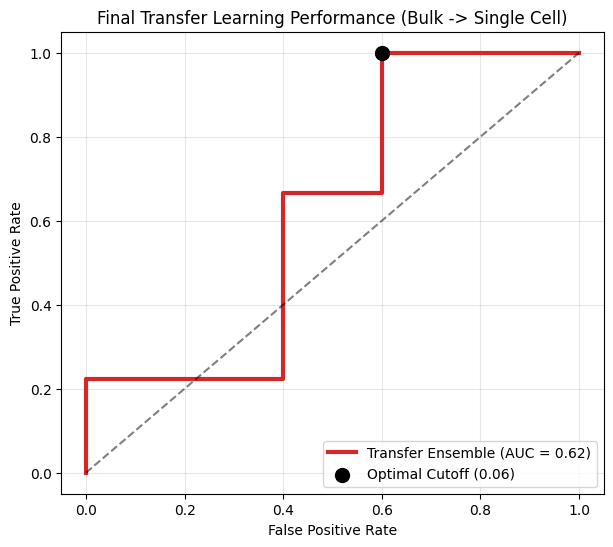

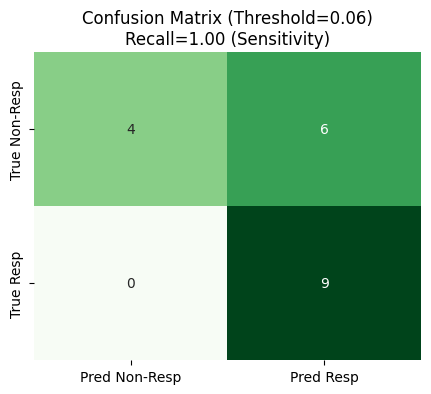

Calculating Gene Importance (this may take a moment)...


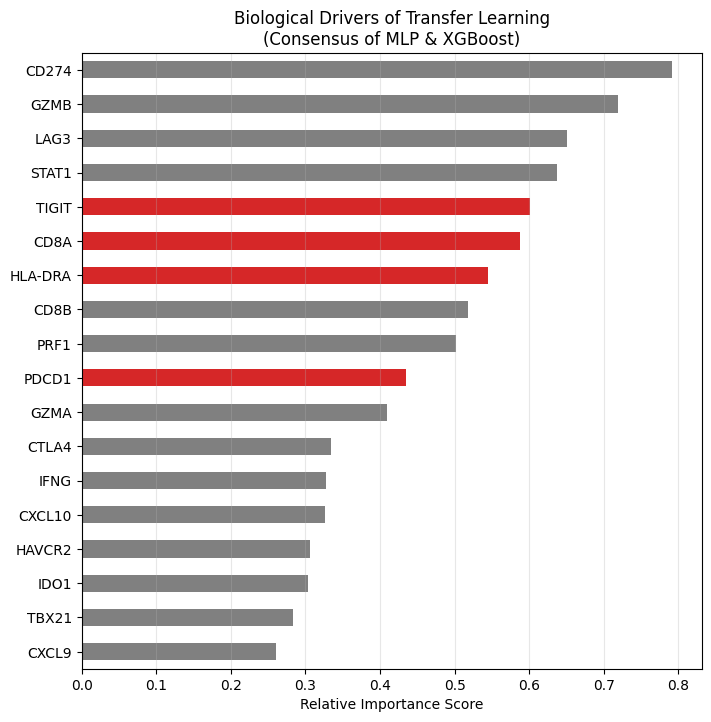

Top 3 Biological Drivers:
CD274    0.791620
GZMB     0.719165
LAG3     0.650201
dtype: float64


In [18]:
# Cell 17: Transfer Learning Visualization & Biology

from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. ENSURE ENSEMBLE IS FITTED
# This fits the combined model for the final prediction
print("Training Final Ensemble...")
ensemble.fit(X_train_fixed, y_train)

# 2. EVALUATE & PLOT ROC (Transfer Learning)
y_prob = ensemble.predict_proba(X_test_fixed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Threshold Optimization
idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]
y_pred_tuned = (y_prob >= best_thresh).astype(int)

# PLOT 1: ROC Curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='#d62728', linewidth=3, label=f'Transfer Ensemble (AUC = {roc_auc:.2f})')
plt.scatter(fpr[idx], tpr[idx], s=100, c='black', label=f'Optimal Cutoff ({best_thresh:.2f})', zorder=10)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Transfer Learning Performance (Bulk -> Single Cell)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# PLOT 2: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred Non-Resp', 'Pred Resp'],
            yticklabels=['True Non-Resp', 'True Resp'])
plt.title(f"Confusion Matrix (Threshold={best_thresh:.2f})\nRecall={cm[1,1]/(cm[1,0]+cm[1,1]):.2f} (Sensitivity)")
plt.show()

# --- BIOLOGICAL EXPLANATION ---
print("Calculating Gene Importance (this may take a moment)...")

#  Fit individual models explicitly so we can analyze them
xgb_tuned.fit(X_train_fixed, y_train)
mlp.fit(X_train_fixed, y_train) #

# 1. Get XGBoost Importance (Built-in)
xgb_imp = pd.Series(xgb_tuned.feature_importances_, index=available_sig)

# 2. Get MLP Importance (Permutation)
perm_results = permutation_importance(mlp, X_test_fixed, y_test, n_repeats=10, random_state=42)
mlp_imp = pd.Series(perm_results.importances_mean, index=available_sig)

# 3. Normalize and Average
# Scale both to 0-1 so we can compare them fairly
xgb_imp_norm = (xgb_imp - xgb_imp.min()) / (xgb_imp.max() - xgb_imp.min())
mlp_imp_norm = (mlp_imp - mlp_imp.min()) / (mlp_imp.max() - mlp_imp.min())

# Combine (Average)
total_imp = (xgb_imp_norm + mlp_imp_norm) / 2
total_imp = total_imp.sort_values(ascending=True)

# PLOT 3: Combined Gene Importance
plt.figure(figsize=(8, 8))
# Highlight critical genes in Red
colors = ['gray' if g not in ['CD8A', 'TIGIT', 'HLA-DRA', 'PDCD1'] else '#d62728' for g in total_imp.index]

total_imp.plot(kind='barh', color=colors)
plt.title("Biological Drivers of Transfer Learning\n(Consensus of MLP & XGBoost)")
plt.xlabel("Relative Importance Score")
plt.grid(axis='x', alpha=0.3)
plt.show()

print("Top 3 Biological Drivers:")
print(total_imp.sort_values(ascending=False).head(3))